In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RGI
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error 

# Dados de entrada

In [2]:
# Dados de entrada
shape = gpd.read_file("C:\\ENS5173\\inputs\\Caçador\\cacador.shp")
df = pd.read_excel("C:\\ENS5173\\inputs\\Plot.xlsx", sheet_name='NOX 1h')

points = []
for i in range(len(df)):
  point = Point(df.loc[i, 'X'], df.loc[i, 'Y'])
  points.append(point)

gdf = gpd.GeoDataFrame(geometry=points).set_crs(epsg='32722')
gdf['AVERAGE CONC'] = df['AVERAGE CONC'] # A planilha do excel foi convertida para um GeoDataFrame

# Criando um DataFrame auxiliar 
xmin, ymin, xmax, ymax = gdf.total_bounds # Valores máximos e mínimos de longitude e latitude do domínio
col, lin = np.arange(xmin, xmax, 500), np.arange(ymin, ymax, 500)

df_aux = pd.DataFrame(columns=col, data=np.zeros((len(lin), len(col))))
df_aux = df_aux.set_index(lin)

for i in range(len(df)):
    df_aux.loc[df.loc[i, 'Y'], df.loc[i, 'X']] = df.loc[i, 'AVERAGE CONC']
 
df_aux.head()

,479218.0,479718.0,480218.0,480718.0,481218.0,481718.0,482218.0,482718.0,483218.0,483718.0,...,524718.0,525218.0,525718.0,526218.0,526718.0,527218.0,527718.0,528218.0,528718.0,529218.0
7012261.0,0.00073,0.00070,0.00067,0.00075,0.00075,0.00065,0.00056,0.00066,0.00070,0.00068,...,0.00078,0.00077,0.00076,0.00074,0.00073,0.00077,0.00075,0.00075,0.00075,0.00073
7012761.0,0.00070,0.00074,0.00071,0.00068,0.00076,0.00075,0.00064,0.00058,0.00068,0.00072,...,0.00079,0.00077,0.00074,0.00074,0.00078,0.00076,0.00078,0.00076,0.00074,0.00076
7013261.0,0.00061,0.00071,0.00076,0.00072,0.00069,0.00077,0.00075,0.00063,0.00060,0.00070,...,0.00078,0.00074,0.00075,0.00079,0.00076,0.00077,0.00077,0.00075,0.00075,0.00073
7013761.0,0.00058,0.00061,0.00072,0.00077,0.00073,0.00070,0.00078,0.00075,0.00062,0.00063,...,0.00076,0.00076,0.00079,0.00076,0.00079,0.00077,0.00076,0.00075,0.00074,0.00064
7014261.0,0.00063,0.00058,0.00062,0.00073,0.00078,0.00074,0.00072,0.00079,0.00075,0.00061,...,0.00077,0.00080,0.00078,0.00080,0.00078,0.00077,0.00076,0.00073,0.00066,0.00069


In [3]:
x = np.array(df_aux.columns.to_list()) # Longitude
y = np.array(df_aux.index.to_list()) # Latitude
z = np.array(df_aux) # Valores que serão interpolados 

# Interpolação 


In [4]:
# Intervalo no qual será feita a interpolação 
gridx = np.arange(xmin, xmax, 100, dtype='float64')
gridy = np.arange(ymin, ymax, 100, dtype='float64')
xi, yi = np.meshgrid(gridx, gridy, indexing='ij', sparse=True)

# Interpolador 
rgi_interp = RGI((x, y), z.T, method='linear', bounds_error=False)

# Aplicar interpolador ao grid
rgi_z = rgi_interp((xi, yi)) 

In [5]:
# Resultados da interpolação
dados = pd.DataFrame(data=rgi_z.T, columns=gridx)
dados = dados.set_index(gridy)
points = []
conc = []
linhas = dados.index.tolist()
colunas = dados.columns.tolist()

for j in range(len(colunas)):
    for i in range(len(linhas)): 
        point = Point(colunas[j], linhas[i])
        points.append(point) 
        conc.append(dados.iloc[i, j])
gdf1 = gpd.GeoDataFrame(geometry=points).set_crs(epsg='32722')
gdf1['conc'] = conc
# Os resultados foram armazenados no GeoDataFrame gdf1 
gdf1.to_crs(epsg='4326', inplace=True) # Conversão das coordenadas

gdf1.head()

,geometry,conc
0,POINT (-51.20949 -27.01162),0.000730
1,POINT (-51.20948 -27.01071),0.000724
2,POINT (-51.20948 -27.00981),0.000718
3,POINT (-51.20948 -27.00891),0.000712
4,POINT (-51.20948 -27.00800),0.000706


In [6]:
# RMSE e MAE 
x1, y1 = np.meshgrid(x, y, indexing='ij', sparse=True)
print('RMSE = '+str(root_mean_squared_error(z, rgi_interp((x1,y1)).T)))
print('MAE = '+str(mean_absolute_error(z, rgi_interp((x1,y1)).T)))

RMSE = 0.0
MAE = 0.0


# Resultados

In [7]:
def generate_color_gradient(n_colors, cmap_name='Reds'):
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, n_colors))
    color_dict = {i: colors[i] for i in range(n_colors)}
    return color_dict

color_dict = generate_color_gradient(6, 'Reds')

# Colormap para colorbar
N = len(color_dict) 
valores = list(color_dict.keys())
cores = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list('', cores, N)

# Colormap para plotar gdf1
valores1 = [0,0.0001,0.0025,0.0050,0.0075,0.0100,0.0125,100]
cores1 = ['none']
cores1 = cores1+cores
cmap1 = LinearSegmentedColormap.from_list('', cores1, N+1) 

In [8]:
# Coordenadas da empresa
coord = {'geometry': [Point(504468, 7037511)]}
empresa = gpd.GeoDataFrame(coord, crs='epsg:32722')
empresa.to_crs(epsg='4326', inplace=True) 

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Vitória Bulhões\AppData\Local\Temp\ipykernel_13140\4161100667.py:34: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('\nConcentração (*10\u207B\u2074 $\mu$g/m\u00b3)', fontsize=18)


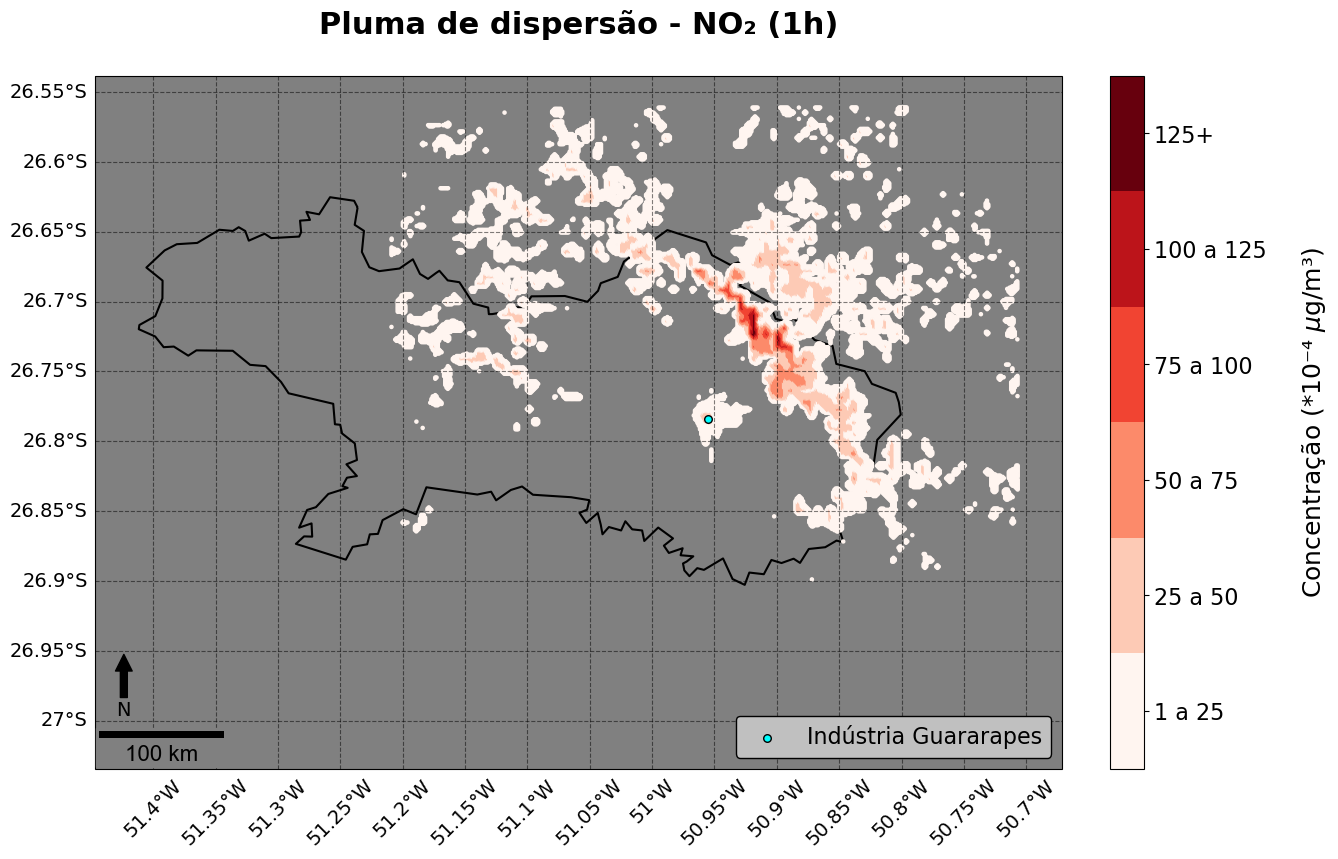

In [10]:
# Criando figura 
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), 
                       figsize=(16.5, 9))
ax.set_facecolor('gray')
shape.plot(ax=ax, color='none', linewidth=1.5)
gdf1.plot(ax=ax, column='conc', cmap=cmap1, markersize=5)
empresa.plot(ax=ax, markersize=30, 
             facecolors='cyan', edgecolors='black', label='Indústria Guararapes')
# Grid
LAT, LON = np.arange(-27, -26, 0.05), np.arange(-51.5, -50.5, 0.05)
gl = ax.gridlines(draw_labels=True,
                  color='black', 
                  alpha=0.5, 
                  linestyle='--')
gl.xlocator = mticker.FixedLocator(LON)
gl.ylocator = mticker.FixedLocator(LAT)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False 
gl.xlabel_style = {'size': 14, 'rotation': 45}
gl.ylabel_style = {'size': 14}

# Colorbar
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
bounds = np.linspace(0,1,N+1) 
cbar=plt.colorbar(sm, ax=ax, boundaries=bounds, 
                  ticks=bounds[:-1] + (bounds[1] - bounds[0]) / 2,
                  fraction=0.04, anchor=(-1,0))
cbar.set_ticklabels(['1 a 25','25 a 50','50 a 75','75 a 100','100 a 125', '125+']) 
cbar.ax.tick_params(labelsize=16)
cbar.set_label('\nConcentração (*10\u207B\u2074 $\mu$g/m\u00b3)', fontsize=18)   
 
# Escala
ax.add_artist(ScaleBar(dx=1,
                       units="km",
                       length_fraction=0.15,
                       scale_formatter=lambda value, unit: f' {value} km ',
                       font_properties={"family": "arial", "size": "16"},
                       location='lower left',
                       box_color="gray"))

# Indicação do norte
a, b = 0.03, 0.165
arrow_length = 0.08
plt.annotate('N', xy=(a, b), xytext=(a, b-arrow_length),
             arrowprops=dict(facecolor='k', width=5, headwidth=12),
             ha='center', va='center', fontsize=14, color='k',
             xycoords=ax.transAxes)

plt.title('Pluma de dispersão - NO\u2082 (1h)\n', weight='bold', fontsize=22)
plt.legend(fontsize=16, framealpha=1, frameon=True, 
           facecolor='silver', edgecolor='black', loc='lower right')
plt.savefig('NO2_1h.png', bbox_inches='tight')
plt.show() 